# Week 6 - Decision Trees and Random Forests

In [2]:
!pip install statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

## First Dataset: Acute Kidney

**Training SVM on Acute Kidney dataset**

In [3]:
# 1) Load data
url = "https://raw.githubusercontent.com/muathdb/Week4/main/Acute%20Kidney.csv"
df = pd.read_csv(url)
# Normalize column names
df.columns = (
    pd.Index(df.columns)
    .astype(str).str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    .str.lower()
)
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]}")

Rows: 4,001  |  Columns: 57


In [4]:
def pick_binary_target(df):
    # Try in order; stage/score columns are binarized (>0 => 1)
    candidate_groups = [
        ["aki"],
        ["aki_injury", "acute_kidney_injury"],
        ["aki_stage", "stage", "aki_score"],
        ["mort_28_day", "mort_30_day", "mortality", "mort_90_day"],  # fallback
    ]
    for group in candidate_groups:
        for col in group:
            if col in df.columns:
                s = df[col]
                if not set(pd.unique(s.dropna())).issubset({0, 1}):
                    s = pd.to_numeric(s, errors="coerce")
                    s = (s.fillna(0) > 0).astype(int)
                    name = f"{col}_binarized"
                else:
                    s = s.astype(int)
                    name = col
                # need both classes
                if s.dropna().nunique() >= 2 and s.sum() > 0 and (len(s) - s.sum()) > 0:
                    return name, s
    raise ValueError("No usable binary target found. Specify one manually (e.g., df['aki']).")

target_name, y = pick_binary_target(df)
print(f"Using target: {target_name!r}  -> positives={int(y.sum())}, negatives={int((1-y).sum())}")

Using target: 'mort_28_day'  -> positives=844, negatives=3157


In [5]:
X_all_num = df.select_dtypes(include=[np.number]).copy()

# Likely leakage columns: explicit labels & post-outcome features
leak_candidates = {
    target_name,
    target_name.replace("_binarized", ""),
    "aki", "aki_injury", "acute_kidney_injury",
    "aki_stage", "aki_score",
    "mort_28_day", "mort_30_day", "mortality", "mort_90_day",
    "mort_1_year", "cox_los"
}
leak_to_drop = [c for c in leak_candidates if c in X_all_num.columns]
if leak_to_drop:
    print("Dropping potential leak columns:", leak_to_drop)

X = X_all_num.drop(columns=leak_to_drop, errors="ignore")

# Extra paranoid: drop any column exactly equal to the target
yr = y.reset_index(drop=True)
identical_cols = []
for c in X.columns:
    s = X[c].reset_index(drop=True)
    try:
        if s.equals(yr):
            identical_cols.append(c)
    except Exception:
        pass
if identical_cols:
    print("Dropping columns identical to target:", identical_cols)
    X = X.drop(columns=identical_cols)

# Basic cleanup
X = X.dropna(axis=1, how="all")
nunique = X.nunique(dropna=True)
X = X.loc[:, nunique[nunique > 1].index]
X = X.fillna(X.median(numeric_only=True))

# Align y
y = y.loc[X.index]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Dropping potential leak columns: ['mort_90_day', 'mort_28_day', 'mort_1_year', 'aki_stage', 'cox_los']



[Decision Tree] CV accuracy: 0.762
[Decision Tree] Test report:
               precision    recall  f1-score   support

           0      0.812     0.915     0.860       632
           1      0.393     0.207     0.271       169

    accuracy                          0.765       801
   macro avg      0.603     0.561     0.566       801
weighted avg      0.723     0.765     0.736       801



<Figure size 600x500 with 0 Axes>

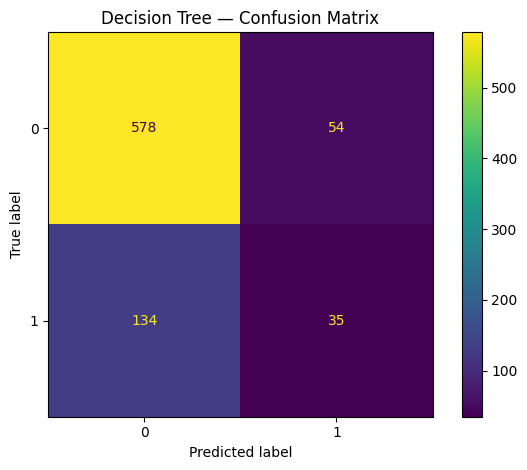

<Figure size 600x500 with 0 Axes>

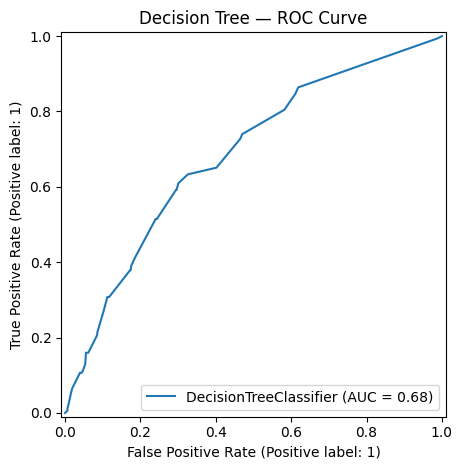

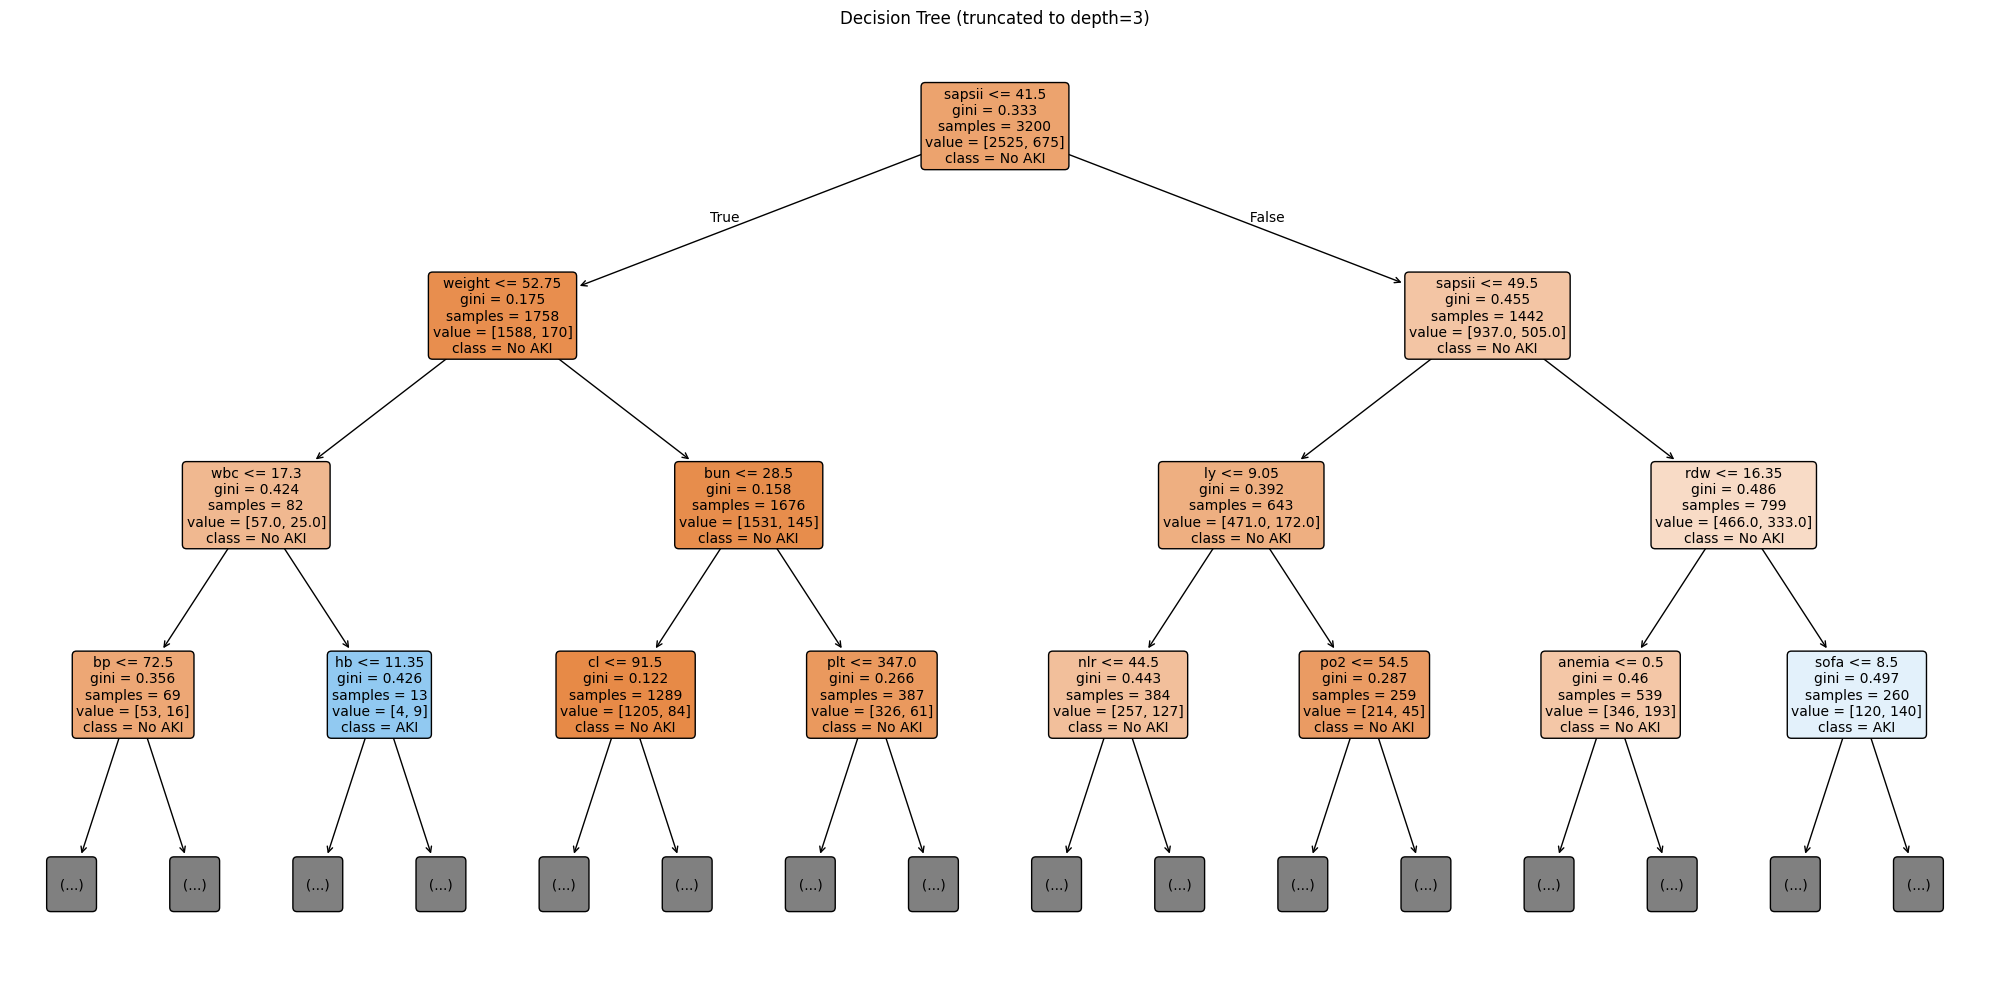

[Decision Tree] Suggested ccp_alpha: 0.004962


In [6]:
#  Decision Tree (with pruning hint)
tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_leaf=5,
    random_state=42
)
tree.fit(X_train, y_train)

cv_acc = cross_val_score(tree, X_train, y_train, cv=5).mean()
print(f"\n[Decision Tree] CV accuracy: {cv_acc:.3f}")
print("[Decision Tree] Test report:\n",
      classification_report(y_test, tree.predict(X_test), digits=3))

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test)
plt.title("Decision Tree — Confusion Matrix")
plt.tight_layout(); plt.show()

if len(np.unique(y_test)) == 2:
    plt.figure(figsize=(6, 5))
    RocCurveDisplay.from_estimator(tree, X_test, y_test)
    plt.title("Decision Tree — ROC Curve")
    plt.tight_layout(); plt.show()

# Truncated tree (avoid overlap)
plt.figure(figsize=(20, 10))
plot_tree(
    tree, feature_names=X.columns.tolist(), class_names=["No AKI", "AKI"],
    filled=True, rounded=True, fontsize=10, max_depth=3
)
plt.title("Decision Tree (truncated to depth=3)")
plt.tight_layout(); plt.show()

# pruning suggestion
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]
if len(ccp_alphas) > 0:
    scores = []
    for a in ccp_alphas:
        t = DecisionTreeClassifier(random_state=42, ccp_alpha=a)
        scores.append(cross_val_score(t, X_train, y_train, cv=5).mean())
    best_alpha = ccp_alphas[int(np.argmax(scores))]
    print(f"[Decision Tree] Suggested ccp_alpha: {best_alpha:.6f}")



[Random Forest] OOB score: 0.806
[Random Forest] CV accuracy: 0.801
[Random Forest] Test report:
               precision    recall  f1-score   support

           0      0.807     0.973     0.882       632
           1      0.564     0.130     0.212       169

    accuracy                          0.795       801
   macro avg      0.686     0.552     0.547       801
weighted avg      0.756     0.795     0.741       801



<Figure size 600x500 with 0 Axes>

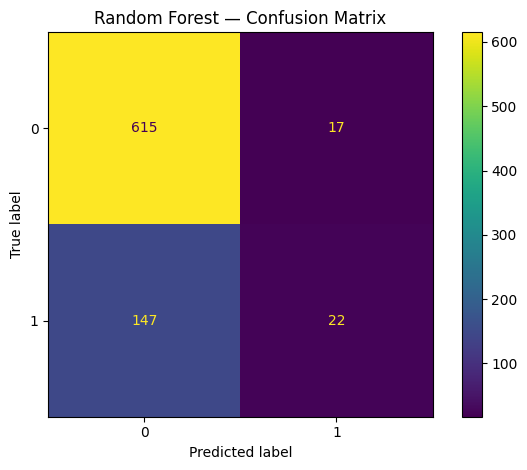

<Figure size 600x500 with 0 Axes>

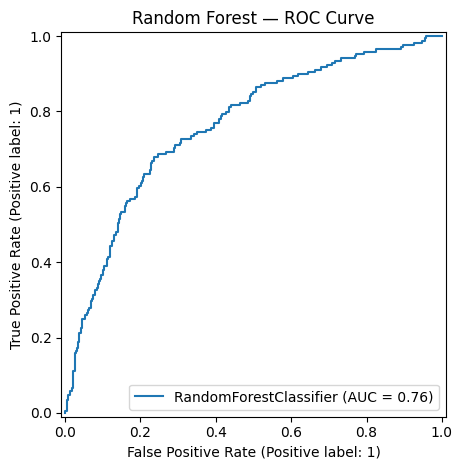

In [7]:
# Random Forest 
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    oob_score=True,
    random_state=42,
    class_weight="balanced"  # helps with imbalance
)
rf.fit(X_train, y_train)

rf_cv = cross_val_score(rf, X_train, y_train, cv=5).mean()
print(f"\n[Random Forest] OOB score: {rf.oob_score_:.3f}")
print(f"[Random Forest] CV accuracy: {rf_cv:.3f}")
print("[Random Forest] Test report:\n",
      classification_report(y_test, rf.predict(X_test), digits=3))

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest — Confusion Matrix")
plt.tight_layout(); plt.show()

if len(np.unique(y_test)) == 2:
    plt.figure(figsize=(6, 5))
    RocCurveDisplay.from_estimator(rf, X_test, y_test)
    plt.title("Random Forest — ROC Curve")
    plt.tight_layout(); plt.show()

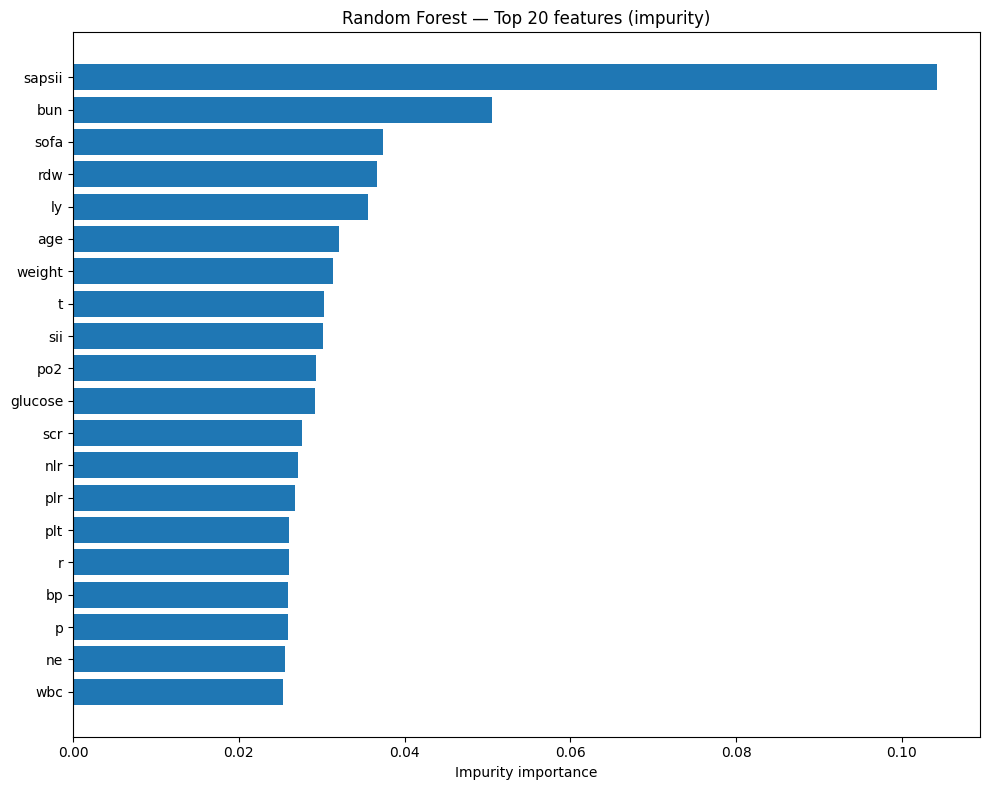


Top permutation importances (refit on top-15 features):
    feature  perm_importance_mean  perm_importance_std
1       bun                0.0065               0.0077
5       age                0.0057               0.0053
9       po2                0.0057               0.0029
10  glucose                0.0045               0.0029
14      plt                0.0035               0.0037
0    sapsii                0.0030               0.0084
12      nlr                0.0027               0.0034
6    weight                0.0025               0.0032
7         t                0.0022               0.0030
13      plr                0.0022               0.0044
8       sii                0.0022               0.0018
11      scr                0.0017               0.0038
4        ly                0.0010               0.0047
3       rdw                0.0002               0.0065
2      sofa               -0.0077               0.0046


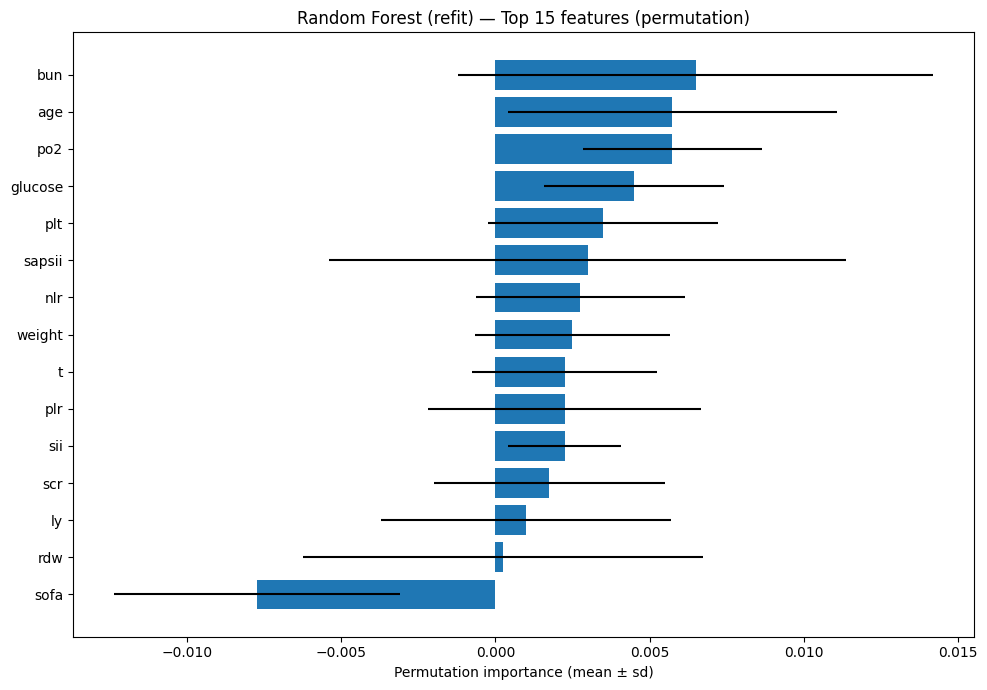

In [8]:
# Feature Importances (impurity + fast permutation)
# (a) Impurity-based (fast) — horizontal bars to avoid overlap
imp_series = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_imp = imp_series.head(20)[::-1]
plt.figure(figsize=(10, 8))
plt.barh(top_imp.index, top_imp.values)
plt.xlabel("Impurity importance")
plt.title("Random Forest — Top 20 features (impurity)")
plt.tight_layout(); plt.show()

# (b) FAST permutation importance:
# Refit a small forest on the top-15 impurity features so fit and perm use the same columns (no mismatch).
top15 = imp_series.head(15).index.tolist()
rf_small = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_leaf=2, max_features="sqrt",
    n_jobs=-1, oob_score=False, random_state=42, class_weight="balanced"
)
rf_small.fit(X_train[top15], y_train)

perm = permutation_importance(
    rf_small, X_test[top15], y_test, n_repeats=5, random_state=42, n_jobs=-1
)
perm_df = (pd.DataFrame({
    "feature": top15,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
}).sort_values("perm_importance_mean", ascending=False))

print("\nTop permutation importances (refit on top-15 features):")
print(perm_df.round(4))

# Plot permutation importances (horizontal, overlap-free)
top_perm = perm_df.head(15).iloc[::-1]
plt.figure(figsize=(10, 7))
plt.barh(top_perm["feature"], top_perm["perm_importance_mean"],
         xerr=top_perm["perm_importance_std"])
plt.xlabel("Permutation importance (mean ± sd)")
plt.title("Random Forest (refit) — Top 15 features (permutation)")
plt.tight_layout(); plt.show()

## Second Dataset: Colorectal cancer

In [9]:
# 1) Load and sample
URL = "https://raw.githubusercontent.com/muathdb/Week4/main/colorectal_cancer_dataset.csv"
df = pd.read_csv(URL)

df.columns = (
    pd.Index(df.columns)
    .astype(str).str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    .str.lower()
)
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]}")

Rows: 167,497  |  Columns: 28


In [10]:
# Pick a binary target (auto)
# Tries common colorectal/oncology labels first; then stage/grade binarized (>0 => 1).
def pick_binary_target(df):
    candidate_groups = [
        # direct binary labels
        ["crc", "colorectal_cancer", "colon_cancer", "rectal_cancer", "cancer", "malignancy", "tumor"],
        ["diagnosis", "outcome", "label", "target", "y", "class"],
        # stage/grade -> binarize (any stage/grade > 0 => 1)
        ["stage", "tumor_stage", "ajcc_stage", "tnm_stage", "grade", "gleason", "path_stage"],
        # survival endpoints as a fallback (will be binarized) — *often post-outcome*, use with care
        ["survival_1_year", "survival_5_year", "mortality", "death_1y", "death_5y"],
    ]
    for group in candidate_groups:
        for col in group:
            if col in df.columns:
                s = df[col]
                # If not already binary, coerce numeric/categorical and binarize (>0 or positive class)
                if not set(pd.unique(s.dropna())).issubset({0, 1}):
                    # Try numeric coercion
                    s_num = pd.to_numeric(s, errors="coerce")
                    if s_num.notna().any():
                        s = (s_num.fillna(0) > 0).astype(int)
                    else:
                        # For strings/cats: treat any non-zero/positive label as 1
                        s = s.astype(str).str.lower()
                        pos_labels = {"yes", "y", "true", "positive", "pos", "cancer", "crc", "malignant"}
                        s = s.isin(pos_labels).astype(int)
                    name = f"{col}_binarized"
                else:
                    s = s.astype(int)
                    name = col
                # Need both classes
                if s.dropna().nunique() >= 2 and s.sum() > 0 and (len(s) - s.sum()) > 0:
                    return name, s
    raise ValueError("No usable binary target found. Please specify one manually, e.g., y = df['crc'].astype(int).")

target_name, y = pick_binary_target(df)
print(f"Using target: {target_name!r}  -> positives={int(y.sum())}, negatives={int((1-y).sum())}")

Using target: 'mortality_binarized'  -> positives=67143, negatives=100354


In [11]:
# Features (drop leakage) 
X_all_num = df.select_dtypes(include=[np.number]).copy()

# Likely leakage/post-outcome columns to drop if present
leak_candidates = {
    target_name,
    target_name.replace("_binarized", ""),
    # direct labels
    "crc", "colorectal_cancer", "colon_cancer", "rectal_cancer", "cancer", "malignancy", "tumor",
    "diagnosis", "outcome", "label", "target", "y", "class",
    # stages/grades (often downstream of diagnosis)
    "stage", "tumor_stage", "ajcc_stage", "tnm_stage", "grade", "gleason", "path_stage",
    # survival/mortality (post-outcome)
    "survival_1_year", "survival_5_year", "mortality", "death_1y", "death_5y",
    # hospital course / LOS style features (often post-index event)
    "los", "length_of_stay", "cox_los",
    # explicit future treatment markers that might occur after outcome
    "chemo_after", "rt_after", "surgery_after", "followup_months"
}
leak_to_drop = [c for c in leak_candidates if c in X_all_num.columns]
if leak_to_drop:
    print("Dropping potential leak columns:", leak_to_drop)

X = X_all_num.drop(columns=leak_to_drop, errors="ignore")

# Extra paranoid: drop any column exactly equal to the target
yr = y.reset_index(drop=True)
identical_cols = []
for c in X.columns:
    s = X[c].reset_index(drop=True)
    try:
        if s.equals(yr):
            identical_cols.append(c)
    except Exception:
        pass
if identical_cols:
    print("Dropping columns identical to target:", identical_cols)
    X = X.drop(columns=identical_cols)

# Basic cleanup
X = X.dropna(axis=1, how="all")
nunique = X.nunique(dropna=True)
X = X.loc[:, nunique[nunique > 1].index]
X = X.fillna(X.median(numeric_only=True))

# Align target
y = y.loc[X.index]

# Train/Test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


[Decision Tree] CV accuracy: 0.598
[Decision Tree] Test report:
               precision    recall  f1-score   support

           0      0.599     1.000     0.749     20071
           1      0.417     0.000     0.001     13429

    accuracy                          0.599     33500
   macro avg      0.508     0.500     0.375     33500
weighted avg      0.526     0.599     0.449     33500



<Figure size 600x500 with 0 Axes>

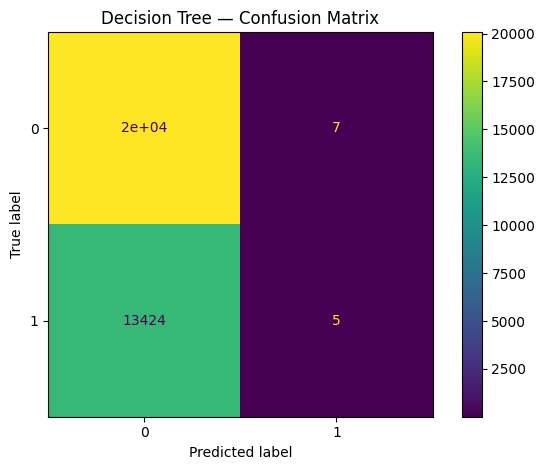

<Figure size 600x500 with 0 Axes>

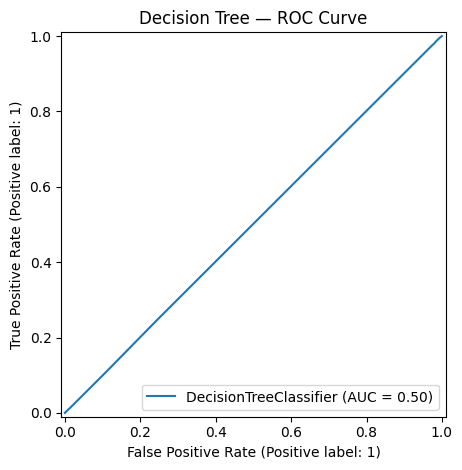

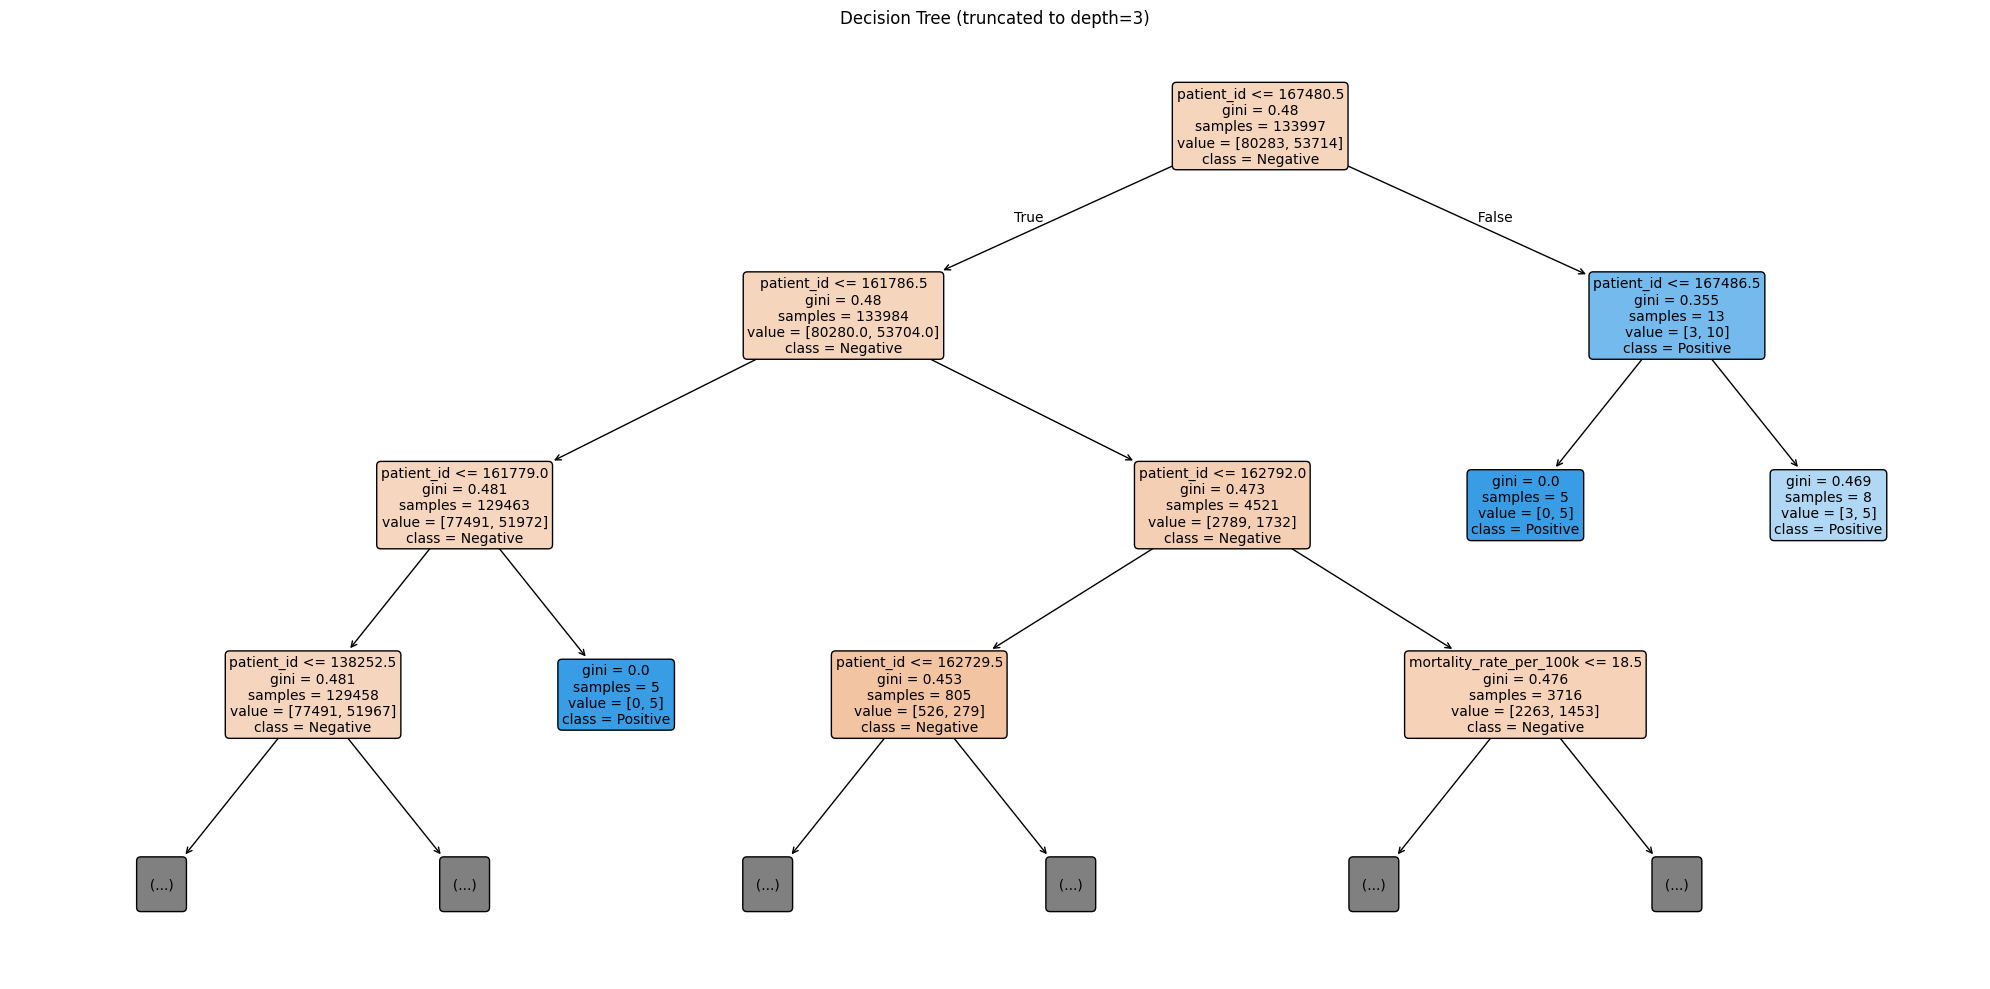

[Decision Tree] Suggested ccp_alpha: 0.000030


In [12]:
#  Decision Tree
tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_leaf=5,
    random_state=42
)
tree.fit(X_train, y_train)

cv_acc = cross_val_score(tree, X_train, y_train, cv=5).mean()
print(f"\n[Decision Tree] CV accuracy: {cv_acc:.3f}")
print("[Decision Tree] Test report:\n",
      classification_report(y_test, tree.predict(X_test), digits=3))

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test)
plt.title("Decision Tree — Confusion Matrix")
plt.tight_layout(); plt.show()

if len(np.unique(y_test)) == 2:
    plt.figure(figsize=(6, 5))
    RocCurveDisplay.from_estimator(tree, X_test, y_test)
    plt.title("Decision Tree — ROC Curve")
    plt.tight_layout(); plt.show()

# Truncated tree (avoid overlap)
plt.figure(figsize=(20, 10))
plot_tree(
    tree, feature_names=X.columns.tolist(), class_names=["Negative", "Positive"],
    filled=True, rounded=True, fontsize=10, max_depth=3
)
plt.title("Decision Tree (truncated to depth=3)")
plt.tight_layout(); plt.show()

# pruning suggestion
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]
if len(ccp_alphas) > 0:
    scores = []
    for a in ccp_alphas:
        t = DecisionTreeClassifier(random_state=42, ccp_alpha=a)
        scores.append(cross_val_score(t, X_train, y_train, cv=5).mean())
    best_alpha = ccp_alphas[int(np.argmax(scores))]
    print(f"[Decision Tree] Suggested ccp_alpha: {best_alpha:.6f}")



[Random Forest] OOB score: 0.566
[Random Forest] CV accuracy: 0.569
[Random Forest] Test report:
               precision    recall  f1-score   support

           0      0.598     0.863     0.707     20071
           1      0.396     0.134     0.201     13429

    accuracy                          0.571     33500
   macro avg      0.497     0.499     0.454     33500
weighted avg      0.517     0.571     0.504     33500



<Figure size 600x500 with 0 Axes>

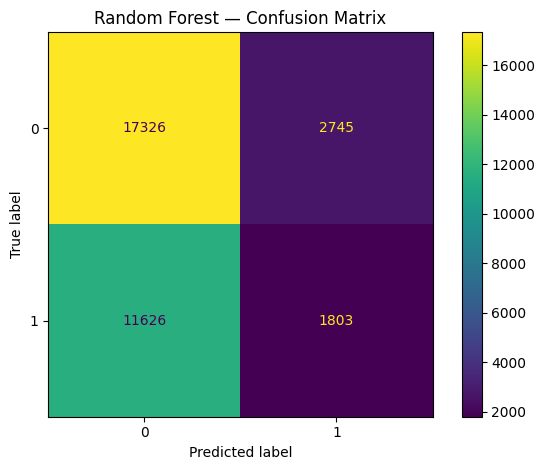

<Figure size 600x500 with 0 Axes>

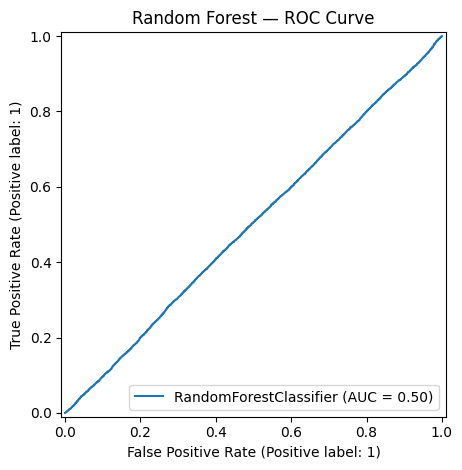

In [13]:
#  Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    oob_score=True,
    random_state=42,
    class_weight="balanced"  # helps with imbalance
)
rf.fit(X_train, y_train)

rf_cv = cross_val_score(rf, X_train, y_train, cv=5).mean()
print(f"\n[Random Forest] OOB score: {rf.oob_score_:.3f}")
print(f"[Random Forest] CV accuracy: {rf_cv:.3f}")
print("[Random Forest] Test report:\n",
      classification_report(y_test, rf.predict(X_test), digits=3))

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest — Confusion Matrix")
plt.tight_layout(); plt.show()

if len(np.unique(y_test)) == 2:
    plt.figure(figsize=(6, 5))
    RocCurveDisplay.from_estimator(rf, X_test, y_test)
    plt.title("Random Forest — ROC Curve")
    plt.tight_layout(); plt.show()


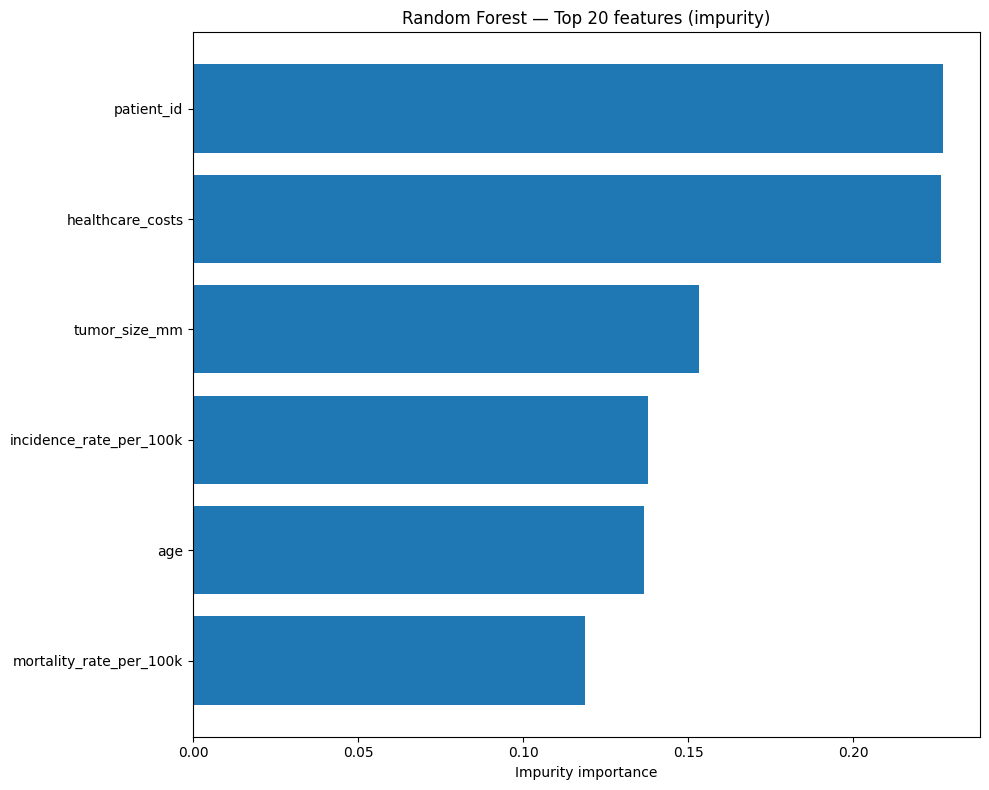

: 

In [14]:
# Feature Importances (impurity + fast permutation)
# 1) Get exact feature names used when rf was fit
feat_names = getattr(rf, "feature_names_in_", None)
if feat_names is None:  # fallback for older sklearn
    feat_names = np.array(X_train.columns)

# 2) Safe impurity-based importances (lengths must match)
imp_series = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)

# Plot horizontally to avoid label overlap
top_imp = imp_series.head(20)[::-1]
plt.figure(figsize=(10, 8))
plt.barh(top_imp.index, top_imp.values)
plt.xlabel("Impurity importance")
plt.title("Random Forest — Top 20 features (impurity)")
plt.tight_layout()
plt.show()

# 3) FAST permutation importance with robust column selection
def pick_topk_available(importance_series, train_cols, k=15):
    """Return up to k feature names from importance_series that exist in train_cols.
       If none exist, fall back to any overlap with rf.feature_names_in_.
       If still empty, fall back to the first min(k, len(train_cols)) columns.
    """
    topk = list(importance_series.index[:k])
    present = [c for c in topk if c in train_cols]
    if len(present) == 0:
        # try any features the model saw that are present now
        present = [c for c in feat_names if c in train_cols][:k]
        if len(present) == 0 and len(train_cols) > 0:
            # last-resort fallback: just take first k train columns
            present = list(train_cols[:k])
    return present

k = 15
present_in_train = pick_topk_available(imp_series, X_train.columns, k=k)

if len(present_in_train) == 0:
    print("[WARN] No usable features available for permutation importance. Skipping PI.")
else:
    # Align reduced matrices
    X_train_small = X_train[present_in_train]
    X_test_small  = X_test[present_in_train]

    # Defensive: ensure at least 1 column and numeric dtypes
    if X_train_small.shape[1] == 0:
        print("[WARN] Reduced feature set is empty after alignment. Skipping PI.")
    else:
        # Refit a small forest on the reduced set (fast & aligned)
        rf_small = RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=2,
            max_features="sqrt",
            n_jobs=-1,
            oob_score=False,
            random_state=42,
            class_weight="balanced"
        )
        rf_small.fit(X_train_small, y_train)

        # 4) Permutation importance on the SAME columns
        perm = permutation_importance(
            rf_small, X_test_small, y_test, n_repeats=5, random_state=42, n_jobs=-1
        )

        perm_df = (
            pd.DataFrame({
                "feature": present_in_train,
                "perm_importance_mean": perm.importances_mean,
                "perm_importance_std": perm.importances_std
            })
            .sort_values("perm_importance_mean", ascending=False)
        )

        print("\nTop permutation importances (refit on aligned top-k features):")
        print(perm_df.round(4))

        # Plot horizontally to prevent overlap
        top_perm = perm_df.head(len(present_in_train)).iloc[::-1]
        plt.figure(figsize=(10, 7))
        plt.barh(
            top_perm["feature"],
            top_perm["perm_importance_mean"],
            xerr=top_perm["perm_importance_std"]
        )
        plt.xlabel("Permutation importance (mean ± sd)")
        plt.title("Random Forest (refit) — Top features (permutation)")
        plt.tight_layout()
        plt.show()

## Third Dataset: Diabetes

In [4]:
# 1) Load Dataset
URL = "https://raw.githubusercontent.com/muathdb/Week4/main/diabetes_012_health_indicators_BRFSS2015.csv"
df = pd.read_csv(URL)

df.columns = (
    pd.Index(df.columns)
    .astype(str).str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    .str.lower()
)
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]}")

Rows: 253,680  |  Columns: 22


In [5]:
# Target variable
# diabetes_012: 0 = No, 1 = Prediabetes, 2 = Diabetes
target_name = "diabetes_012"
y = (df[target_name] == 2).astype(int)   # 1 for diabetes, 0 otherwise
print(f"Target: {target_name!r}  -> positives={y.sum()}, negatives={(1 - y).sum()}")

Target: 'diabetes_012'  -> positives=35346, negatives=218334


In [6]:
#  Features (drop leakage)
X = df.drop(columns=[target_name], errors="ignore")

# Train/Test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


[Decision Tree] CV accuracy: 0.865
[Decision Tree] Test report:
               precision    recall  f1-score   support

           0      0.871     0.989     0.926     43667
           1      0.583     0.093     0.160      7069

    accuracy                          0.864     50736
   macro avg      0.727     0.541     0.543     50736
weighted avg      0.831     0.864     0.819     50736



<Figure size 600x500 with 0 Axes>

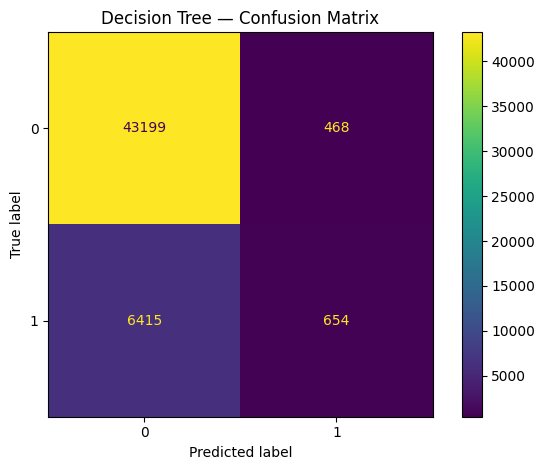

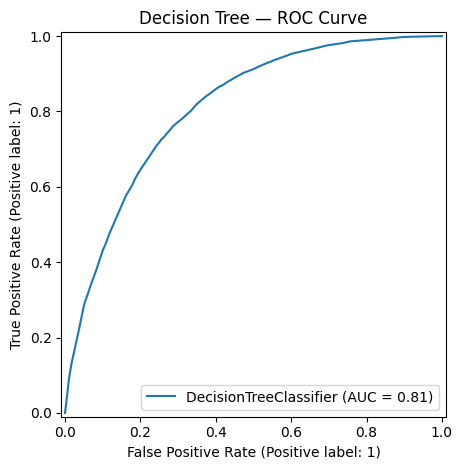

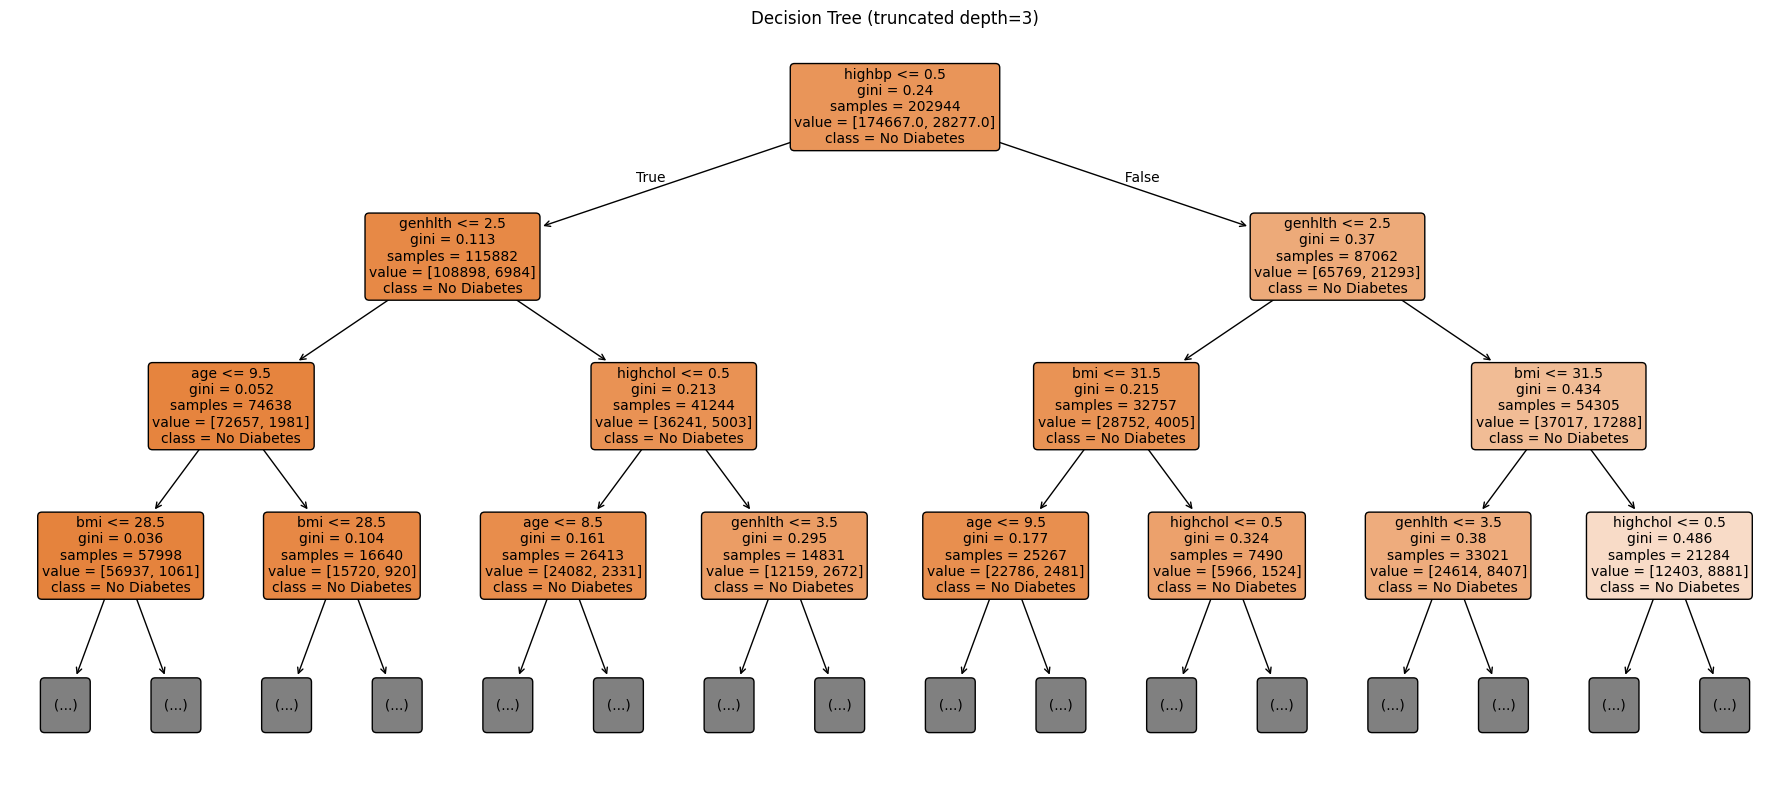

In [7]:
# Decision Tree
tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_leaf=5,
    random_state=42
)
tree.fit(X_train, y_train)

cv_acc = cross_val_score(tree, X_train, y_train, cv=5).mean()
print(f"\n[Decision Tree] CV accuracy: {cv_acc:.3f}")
print("[Decision Tree] Test report:\n",
      classification_report(y_test, tree.predict(X_test), digits=3))

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test)
plt.title("Decision Tree — Confusion Matrix")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_estimator(tree, X_test, y_test)
plt.title("Decision Tree — ROC Curve")
plt.tight_layout()
plt.show()

# Show truncated tree
plt.figure(figsize=(18, 8))
plot_tree(tree, feature_names=X.columns, class_names=["No Diabetes", "Diabetes"],
          filled=True, rounded=True, fontsize=10, max_depth=3)
plt.title("Decision Tree (truncated depth=3)")
plt.tight_layout()
plt.show()

In [8]:
#  Random Forest 
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    oob_score=True,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

rf_cv = cross_val_score(rf, X_train, y_train, cv=5).mean()
print(f"\n[Random Forest] OOB score: {rf.oob_score_:.3f}")
print(f"[Random Forest] CV accuracy: {rf_cv:.3f}")
print("[Random Forest] Test report:\n",
      classification_report(y_test, rf.predict(X_test), digits=3))

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest — Confusion Matrix")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest — ROC Curve")
plt.tight_layout()
plt.show()

: 

In [ ]:
# Feature Importances (impurity + fast permutation)
feat_names = getattr(rf, "feature_names_in_", None)
if feat_names is None:
    feat_names = X_train.columns.to_numpy()

imp_series = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)

# Impurity-based 
top_imp = imp_series.head(20)[::-1]
plt.figure(figsize=(10, 8))
plt.barh(top_imp.index, top_imp.values)
plt.xlabel("Impurity importance")
plt.title("Random Forest — Top 20 features (impurity)")
plt.tight_layout()
plt.show()

# FAST permutation importance (refit small model)
k = 15
topk = imp_series.head(k).index.tolist()
present_in_train = [c for c in topk if c in X_train.columns]
if len(present_in_train) == 0:
    present_in_train = list(X_train.columns[:k])

X_train_small = X_train[present_in_train]
X_test_small  = X_test[present_in_train]

rf_small = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
    class_weight="balanced"
)
rf_small.fit(X_train_small, y_train)

perm = permutation_importance(
    rf_small, X_test_small, y_test, n_repeats=5, random_state=42, n_jobs=-1
)
perm_df = (
    pd.DataFrame({
        "feature": present_in_train,
        "perm_importance_mean": perm.importances_mean,
        "perm_importance_std": perm.importances_std
    })
    .sort_values("perm_importance_mean", ascending=False)
)

print("\nTop permutation importances (refit on top-15 features):")
print(perm_df.round(4))

top_perm = perm_df.head(len(present_in_train)).iloc[::-1]
plt.figure(figsize=(10, 7))
plt.barh(top_perm["feature"], top_perm["perm_importance_mean"],
         xerr=top_perm["perm_importance_std"])
plt.xlabel("Permutation importance (mean ± sd)")
plt.title("Random Forest (refit) — Top features (permutation)")
plt.tight_layout()
plt.show()